## Link to Colab

In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Downloading Dependencies

In [2]:
# install torchaudio
!pip install torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 6.2MB/s 
     |████████████████████████████████| 577.3MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu92 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [3]:
import os
import numpy as np
import pandas as pd

# for F1-score & confusion matrix later
from sklearn.metrics import classification_report
import seaborn as sns

# current torch version is 1.7.0+cu101
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
import torchaudio
from torchaudio.transforms import MelSpectrogram
from torchaudio.transforms import TimeMasking, FrequencyMasking

import matplotlib.pyplot as plt
import IPython.display as ipd

import time
import random
from tqdm import tqdm

# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/TIL2021/competition/SC/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

cuda


## Speech Classification Dataset
We will be providing the base dataset that will be used for the first task of the Speech Classification competition.

In [4]:
!gdown --id 1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
!unzip s1_train_release.zip

Downloading...
From: https://drive.google.com/uc?id=1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
To: /content/s1_train_release.zip
48.3MB [00:00, 78.5MB/s]
Archive:  s1_train_release.zip
   creating: s1_train_release/bird/
  inflating: s1_train_release/bird/train_bird_8400.wav  
  inflating: s1_train_release/bird/train_bird_8401.wav  
  inflating: s1_train_release/bird/train_bird_8402.wav  
  inflating: s1_train_release/bird/train_bird_8405.wav  
  inflating: s1_train_release/bird/train_bird_8406.wav  
  inflating: s1_train_release/bird/train_bird_8407.wav  
  inflating: s1_train_release/bird/train_bird_8408.wav  
  inflating: s1_train_release/bird/train_bird_8409.wav  
  inflating: s1_train_release/bird/train_bird_8411.wav  
  inflating: s1_train_release/bird/train_bird_8416.wav  
  inflating: s1_train_release/bird/train_bird_8417.wav  
  inflating: s1_train_release/bird/train_bird_8419.wav  
  inflating: s1_train_release/bird/train_bird_8420.wav  
  inflating: s1_train_release/bird/train_bird_8

In [5]:
class CustomSpeechDataset(torch.utils.data.Dataset):
  def __init__(self, path, typ='train', transforms=None):

    assert typ == 'train' or typ == 'test', 'typ must be either "train" or "test"'

    self.typ = typ
    self.transforms = transforms
    self.targets = []

    if self.typ == 'train':
      self.class_names = sorted(os.listdir(path))
      num_classes = len(self.class_names)

      for class_idx, class_name in enumerate(self.class_names):
        class_dirx = os.path.join(path, class_name)
        wav_list = os.listdir(class_dirx)

        for wav_file in wav_list:
          self.targets.append({
              'filename': wav_file,
              'path': os.path.join(class_dirx, wav_file),
              'class': class_name
          })

    if self.typ == 'test':
      wav_list = os.listdir(path)
      for wav_file in wav_list:
        self.targets.append({
            'filename': wav_file,
            'path': os.path.join(path, wav_file)
        })
  
  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()

    # sr is the sampling rate
    signal, sr = torchaudio.load(self.targets[idx]['path'], normalization=True)
    filename = self.targets[idx]['filename']

    if self.transforms:
      for transform in self.transforms:
        signal = transform(signal)

    if self.typ == 'train':
      clx_name = self.targets[idx]['class']
      return filename, signal, sr, clx_name
    
    elif self.typ == 'test':
      return filename, signal, sr

# helper function to check the time taken to train an epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [6]:
fd = CustomSpeechDataset(path='s1_train_release', typ='train')
train_size = int(len(fd)*0.8)
valid_size = len(fd) - train_size
print(train_size, valid_size)
# train test split
#train_set, valid_set = torch.utils.data.random_split(fd, [train_size, valid_size])

2080 520


In [7]:
# turn the custom dataset into a list of data
full_dataset = list(fd)
list(full_dataset)[:2]

[('train_bird_8606.wav',
  tensor([[-0.0066, -0.0077, -0.0074,  ..., -0.0076, -0.0092, -0.0096]]),
  16000,
  'bird'),
 ('train_bird_8663.wav',
  tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
  16000,
  'bird')]

In [8]:
len(full_dataset)

2600

In [9]:
labels = fd.class_names
print(labels)

['bird', 'eight', 'falcon', 'five', 'four', 'nine', 'one', 'seven', 'six', 'snake', 'three', 'two', 'zero']


In [10]:
labels_to_indices = {}
for idx, l in enumerate(labels):
  labels_to_indices[l] = idx

In [11]:
print(labels_to_indices)

{'bird': 0, 'eight': 1, 'falcon': 2, 'five': 3, 'four': 4, 'nine': 5, 'one': 6, 'seven': 7, 'six': 8, 'snake': 9, 'three': 10, 'two': 11, 'zero': 12}


## Manual kFold implementation
Create kFold data for later part of this notebook

In [12]:
# define a class that gets the complement of the list
class ComplementList(list):
    def __getitem__(self, val):
        if type(val) is slice and val.step == 'c':
            copy = self[:]
            copy[val.start:val.stop] = []
            return copy

        return super(ComplementList, self).__getitem__(val)

# testing the class implementation
l = ComplementList([1,2,3,4,5])
print(l[2:4:'c']) # [1, 5]

[1, 2, 5]


In [13]:
# define the k-fold constant
K = 5

# k is the k-fold constant, fd is the full dataset in list
def manual_k_fold(k, fd, fd_length):
    val_list = []
    train_list = []

    # randomise the dataset first
    random.shuffle(fd)

    # get the combinations of splits for the validation set
    for i in tqdm(range(k)):
        val_list.append(fd[int((i/k)*fd_length):int(((i+1)/k)*fd_length)])
        clist = ComplementList(fd)
        train_list.append(clist[int((i/k)*fd_length):int(((i+1)/k)*fd_length):'c'])

    return val_list, train_list

In [14]:
val_list, train_list = manual_k_fold(K, full_dataset, len(full_dataset))

100%|██████████| 5/5 [00:00<00:00, 2156.68it/s]


In [15]:
len(train_list[0]) , len(val_list[0])

(2080, 520)

In [17]:
# an example
# [fold][item set][particular file]
#print(val_list[0][0][0]) 
#print(val_list[1][0][0]) 
#print(val_list[2][0][0]) 
#print(val_list[3][0][0]) 
#print(val_list[4][0][0]) 

## Get the data distribution of each class

In [18]:
def train_data_distribution(data):
    train_filename_list = []
    train_label_list = []
    for i in range(len(data)):
        train_filename_list.append(data[i][0])
        train_label_list.append(data[i][3])

    # make to dataframe
    train_tuple = list(zip(train_filename_list, train_label_list))
    train_df = pd.DataFrame(train_tuple, columns=['train_filename', 'train_label'])

    return train_df

In [19]:
for i in range(K):
    print(f"Train Set {i+1}")
    train_dist = train_data_distribution(train_list[i])
    #print(train_dist.head(3))
    # find the count of each label to check distribution of the labels
    print(train_dist["train_label"].value_counts())
    print()

Train Set 1
six       173
five      170
nine      170
zero      164
bird      162
seven     159
one       158
snake     157
three     156
falcon    155
two       154
four      152
eight     150
Name: train_label, dtype: int64

Train Set 2
four      169
falcon    167
two       163
seven     161
five      160
three     160
six       159
zero      159
nine      159
bird      156
snake     156
one       156
eight     155
Name: train_label, dtype: int64

Train Set 3
two       171
zero      166
three     165
eight     165
falcon    162
four      162
snake     160
five      159
one       157
seven     157
nine      155
six       152
bird      149
Name: train_label, dtype: int64

Train Set 4
one       171
five      166
bird      166
eight     165
falcon    163
three     163
snake     163
nine      160
seven     159
six       156
four      152
two       149
zero      147
Name: train_label, dtype: int64

Train Set 5
bird      167
four      165
eight     165
snake     164
zero      164
seven     

## Look at one example from the training set

In [ ]:
train_list[0][1]

('train_snake_0120.wav',
 tensor([[ 1.8311e-04, -6.1035e-05,  6.1035e-05,  ..., -6.3171e-03,
          -5.1880e-03, -3.8757e-03]]),
 16000,
 'snake')

In [ ]:
filename, waveform, sample_rate, label_id = train_list[0][1]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


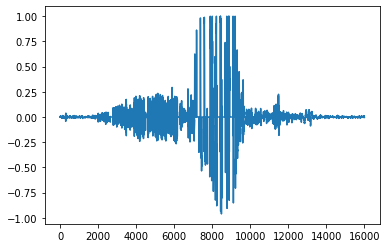

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Let's plot the waveform using matplotlib
# We observe that the main audio activity happens at the later end of the clip
plt.plot(waveform.t().numpy());

In [ ]:
# let's play the audio clip and hear it for ourselves!
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Constant Sample Lengths
In order to insert our features into a model, we have to ensure that the features are of the same size. Below, we see that the sample length varies across the audio clips.

Let's pad the audio clips to a maximum sample length of 16000. (16000 sample length is equal to 1 second at 16,000 Hz sampling rate)
We will pad audio clips which are less than 1 second in length, with parts of itself.

In [20]:
# checking the first fold
audio_lens = []
for i in range(len(train_list[0])):
  audio_lens.append(train_list[0][i][1].size(1))

print('Max Sample Length:', max(audio_lens))
print('Min Sample Length:', min(audio_lens))

Max Sample Length: 16000
Min Sample Length: 16000


## Fixed Hyperparameters

In [21]:
# data augmentation -> have to fix this two, as it is a global implementation
# create multiple notebooks for different values of these two hyperparameters
TIME_MASK_PARAM = 5
FREQ_MASK_PARAM = 5

## Data Augmentation

Since the min and the max length is the same and hence no need to pad the audio, else can run PadAudio and the shorter ones will be repeated with its own audio

We will do a simple data augmentation process in order to increase the variations in our dataset.

In the audio domain, the augmentation technique known as [SpecAugment](https://arxiv.org/abs/1904.08779) is often used. It makes use of 3 steps:
- Time Warp (warps the spectrogram to the left or right) 2nd row
- Frequency Masking (randomly masks a range of frequencies) 3rd row
- Time Masking (randomly masks a range of time) 4th row

![specaugment pic](https://drive.google.com/uc?export=view&id=1C085-PlXVhjzh4kzCy869VHRGwC3aDHJ)

As Time Warp is computationally intensive and does not contribute significant improvement in results, we shall simply use Frequency and Time Masking in this example.

In [22]:
# pad the audio to the same length
class PadAudio(torch.nn.Module):
    def __init__(self, req_length = 16000):
        super().__init__()
        self.req_length = req_length

    def forward(self, waveform):
        while waveform.size(1) < self.req_length:
        # example if audio length is 15800 and max is 16000, the remaining 200 samples will be concatenated
        # with the FIRST 200 samples of the waveform itself again (repetition)
            waveform = torch.cat((waveform, waveform[:, :self.req_length - waveform.size(1)]), axis=1)
        return waveform

# Log-Mel Transform here to get ready to train with our RNN model later on
class LogMelTransform(torch.nn.Module):

    def __init__(self, log_offset = 1e-6):
        super().__init__()
        self.log_offset = log_offset

    def forward(self, melspectrogram):
        return torch.log(melspectrogram + self.log_offset)

# define a transformation sequence
def transform_sequence(time_mask, freq_mask):
    transformations = []
    transformations.append(PadAudio())
    transformations.append(MelSpectrogram(sample_rate = 16000, n_mels = 128))
    transformations.append(LogMelTransform())
    eval_transformations = transformations.copy()
    # a maximum of 5 time steps will be masked
    transformations.append(TimeMasking(time_mask_param = time_mask)) 
    # maximum of 3 freq channels will be masked
    transformations.append(FrequencyMasking(freq_mask_param = freq_mask))
    return transformations, eval_transformations

In [23]:
transformations, eval_transformations = transform_sequence(TIME_MASK_PARAM, FREQ_MASK_PARAM)
print(transformations)

[PadAudio(), MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
), LogMelTransform(), TimeMasking(), FrequencyMasking()]


## Data Loaders

Let's now set up our data loaders so that we can streamline the batch loading of data for our model training later on. 

In [24]:
# Fixed parameters
NUM_WORKERS = 4
PIN_MEMORY = True if device == 'cuda' else False

def train_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)

    return (tensors, targets, filenames)

def eval_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)
    filenames += [filename]

    return (tensors, targets, filenames)

def loader(train_set, valid_set, batch_size=64, num_workers=NUM_WORKERS, pin_mem=PIN_MEMORY):
    # implementing the loader function
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        collate_fn=train_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_mem,
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_set,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=eval_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_mem,
    )

    return train_loader, valid_loader

## Setting up and defining the Model and training loop

In this speech classification example, we will make use of a Long-Short-Term Memory Recurrent Neural Network (LSTM-RNN).

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # hidden_size * 2 cuz bidirectional
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        # bidirectional so need to multiply the layers by 2 for initial state
        h0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(self.device) 

        # only applicable to LSTM because LSTM got 2 gates but GRU only has one!!!
        #c0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0.detach())  # shape = (batch_size, seq_length, hidden_size)
        # lstm implementation
        #out, _ = self.gru(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index


'''# initialize the model class
model = RNN(input_size=128, 
            hidden_size=HIDDEN_SIZE, 
            num_layers=NUM_LAYERS, 
            num_classes=len(labels), 
            device=device, 
            classes=labels).to(device)
print(model)'''

# define a function to train the model
def fit(model, train_loader, valid_loader, num_epochs, fold_num, optim_flag='adam'):
    # fixed configuration
    criterion = nn.CrossEntropyLoss()
    
    # choice of optimizers
    if optim_flag == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    elif optim_flag == 'sgd99':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.99)
    elif optim_flag == 'sgd90':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    elif optim_flag == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # included a weight decay of 1e-02 for adam
    elif optim_flag == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
    elif optim_flag == 'adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1)
    elif optim_flag == 'adamax':
        optimizer = torch.optim.Adamax(model.parameters(), lr=2e-3)
    else:
        return "No such optimizer, try again"

    # set the LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.1, 
                                                           patience=3, 
                                                           min_lr=1e-5,
                                                           verbose=True)
    
    # fixed parameters to perform early stopping
    n_epochs_stop = 5
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.inf
    threshold = 0.0001
    optimizer.zero_grad()

    # declare the fold number
    print(f'---------- Fold Number: {fold_num} ----------')

    # start the training loop
    for epoch in range(1,num_epochs+1):

        start_time = time.time()
        # training steps
        model.train()
        count_correct, count_total = 0, 0
        for idx, (features, targets, filenames) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = model(features)
            loss = criterion(outputs, targets)

            # backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # training results
            _, argmax = torch.max(outputs, 1)
            count_correct += (targets == argmax.squeeze()).sum().item()
            count_total += targets.size(0)

        train_acc = count_correct / count_total
    
        # evaluation steps
        model.eval()
        count_correct, count_total = 0, 0
        val_pred_list, val_filename_list = [], []
        
        with torch.no_grad():
            for idx, (features, targets, filenames) in enumerate(valid_loader):

                features = features.to(device)
                targets = targets.to(device)

                # forward pass
                val_outputs = model(features)
                val_loss = criterion(val_outputs, targets)

                # validation results
                _, argmax = torch.max(val_outputs, 1)
                count_correct += (targets == argmax.squeeze()).sum().item()
                count_total += targets.size(0)
                val_pred_list += argmax.cpu().tolist()
                val_filename_list += filenames
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # print results
        valid_acc = count_correct / count_total
        if epoch<=3 or epoch%5==0:
            print('Epoch [{}/{}]: Train loss = {:.4f}, Train accuracy = {:.2f}, Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
                    .format(epoch, num_epochs, loss.item(), 100*train_acc, val_loss.item(), 100*valid_acc))
            print(f'Time taken for Epoch {epoch}: {epoch_mins}m {epoch_secs}s')
        
        # add the scheduler code
        scheduler.step(val_loss)

        # --- EARLY STOPPING CONDITION ---
        if val_loss.item() < min_val_loss+threshold: # give some threshold to make the learning less strict
            # resets the no improve counter
            epochs_no_improve = 0
            min_val_loss = val_loss.item()
        else: # val_loss no improvement
            epochs_no_improve +=1
            print(f"Validation Loss did not improve count: {epochs_no_improve}")
            # set this line as min now
            min_val_loss = val_loss.item()
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print("Training stopped due to early stopping!")
            break
        else:
            continue

    return val_loss.item(), 100*valid_acc, val_pred_list, val_filename_list, loss.item(), 100*train_acc

## Configuration for a trained model
- Declare hyperparameters
- Training the model
- Check and save the best fold
- F1-score analysis
- Confusion Matrix
- Load model back to try it on the test set

## Helper Functions

In [26]:
# ----- TRAINING THE MODEL -----
def train_helper(num_folds, train_list, val_list, batch_size, hidden_size, num_layers, epochs, optim_flag='adam'):

    # data loader for all the k-fold datasets
    train_loader_list = []
    valid_loader_list = []

    for i in range(num_folds):
        train_loader, valid_loader = loader(train_list[i], val_list[i], batch_size)
        train_loader_list.append(train_loader)
        valid_loader_list.append(valid_loader)

    # initialise list to store the kth folds results
    loss_list = [] # validation
    acc_list = [] # validation
    val_pred_array = []
    val_filename_array = []
    model_state_list = []
    train_loss_list = [] # train
    train_acc_list = [] # train

    # 5-fold loop
    for i in range(num_folds):
        # intialise the model class
        model = RNN(input_size=128, hidden_size=hidden_size, num_layers=num_layers, num_classes=len(labels), device=device, classes=labels).to(device)
        print(model)
        print()

        # fit the model for training
        val_loss, val_acc, val_pred_list, val_filename_list, train_loss, train_acc = fit(model=model, 
                                                                                         train_loader=train_loader_list[i], 
                                                                                         valid_loader=valid_loader_list[i], 
                                                                                         num_epochs=epochs, 
                                                                                         fold_num=i+1, 
                                                                                         optim_flag=optim_flag)
        loss_list.append(val_loss)
        acc_list.append(val_acc)
        val_pred_array.append(val_pred_list)
        val_filename_array.append(val_filename_list)
        model_state_list.append(model)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

    return loss_list, acc_list, val_pred_array, val_filename_array, model_state_list, train_loss_list, train_acc_list

# ----- CHECK BEST FOLD BASED ON VALIDATION ACCURACY AND SAVE BEST FOLD MODEL -----
def save_best_fold(loss_list, acc_list, model_state_list, train_loss_list, train_acc_list, filename):
    # ----- CHECK THE BEST FOLD MODEL BASED ON MODEL VALIDATION ACCURACY -----
    print(f'Train Losses: {train_loss_list}')
    print(f'Train Accuracies: {train_acc_list}')
    print(f'Validation Losses: {loss_list}')
    print(f'Validation Accuracies: {acc_list}')
    best_fold_index = acc_list.index(max(acc_list))
    print(f'Best fold: {best_fold_index+1}')

    # ----- SAVE THE BEST FOLD MODEL -----
    torch.save(model_state_list[best_fold_index].state_dict(), f'{COLAB_FILEPATH}model/model-{filename}.pt')  
    print(f'Model Saved for Fold {best_fold_index+1}')
    return best_fold_index

# ----- F1 & CONFUSION MATRIX -----
def metrics_helper(val_list, val_filename_array, val_pred_array, best_fold_index, filename):
    # ----- F1-Score Analysis -----
    # get the pred and filename
    val_tuple = list(zip(val_filename_array[best_fold_index], val_pred_array[best_fold_index]))
    val_df = pd.DataFrame(val_tuple, columns=['val_filename', 'val_label_pred_num'])
    val_df['val_label_pred'] = val_df['val_label_pred_num'].apply(lambda x: labels[x])
    #val_df.head()

    # make a combined data frame by iteratively appending the values to a list
    val_filename_list_final = []
    val_true_list = []
    for i in range(len(val_list[best_fold_index])):
        val_filename_list_final.append(val_list[best_fold_index][i][0])
        val_true_list.append(val_list[best_fold_index][i][3])

    # make to dataframe
    val_tuple_final = list(zip(val_filename_list_final, val_true_list))
    #print(result_tuple)
    val_df_final = pd.DataFrame(val_tuple_final, columns=['val_filename', 'val_label_true'])
    #val_df_final.head()
    # append the predicted column into the final dataframe
    val_df_final['val_label_pred'] = val_df['val_label_pred']
    #val_df_final.head(3)

    # save the table to csv
    val_df_final.to_csv(f"{COLAB_FILEPATH}f1-table/f1-{filename}.csv", index=False)

    # import the csv back again
    #val_df_final = pd.read_csv(f"{COLAB_FILEPATH}f1-table/f1-{filename}.csv")
    #val_df_final.head()

    # simple check if length of data are equal
    assert len(val_df_final["val_label_true"]) == len(val_df_final["val_label_pred"])

    # get the multi-class F1-score to see the distribution of the predictions
    print(classification_report(list(val_df_final['val_label_true']), list(val_df_final['val_label_pred']), target_names=labels, digits=4))
    print()

    # confusion matrix
    cm_sns = pd.crosstab(val_df_final['val_label_true'], val_df_final['val_label_pred'], rownames=['Actual'], colnames=['Predicted'])
    plt.subplots(figsize=(12,10))
    sns.heatmap(cm_sns, annot=True, fmt="d", cmap='YlGnBu_r')
    plt.show()

# CONFIGURATION 1 - Adagrad & Batch size 32
- Hidden Size: 256
- Number of layers: 2
- Batch Size: 32
- Optimizer: Adagrad
- Epoch: 30

In [27]:
# ----- DECLARE HYPERPARAMETERS -----
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30

# ----- EXPORTED FILENAME -----
FILENAME = f'SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}'
print(f'Filename: {FILENAME}\n')

# ----- TRAINING THE K-FOLD MODEL -----
loss_list, acc_list, val_pred_array, val_filename_array, model_state_list, train_loss_list, train_acc_list = train_helper(num_folds=K, 
                                                                                                                          train_list=train_list, 
                                                                                                                          val_list=val_list, 
                                                                                                                          batch_size=BATCH_SIZE, 
                                                                                                                          hidden_size=HIDDEN_SIZE, 
                                                                                                                          num_layers=NUM_LAYERS, 
                                                                                                                          epochs=EPOCHS, 
                                                                                                                          optim_flag=OPTIM_NAME)

Filename: SC-BiGru_lr-1e-03_TM-5_FM-5_HS-256_NL-2_BS-32_OP-adagrad_EP-30

RNN(
  (gru): GRU(128, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=13, bias=True)
)

---------- Fold Number: 1 ----------
Epoch [1/30]: Train loss = 2.1761, Train accuracy = 11.59, Valid loss = 3.0601, Valid accuracy = 7.88
Time taken for Epoch 1: 0m 3s
Epoch [2/30]: Train loss = 1.3482, Train accuracy = 30.63, Valid loss = 1.7299, Valid accuracy = 37.69
Time taken for Epoch 2: 0m 3s
Epoch [3/30]: Train loss = 1.0671, Train accuracy = 59.28, Valid loss = 0.9556, Valid accuracy = 70.77
Time taken for Epoch 3: 0m 3s
Epoch [5/30]: Train loss = 0.6740, Train accuracy = 83.32, Valid loss = 0.9019, Valid accuracy = 81.73
Time taken for Epoch 5: 0m 3s
Validation Loss did not improve count: 1
Epoch [10/30]: Train loss = 0.3929, Train accuracy = 94.23, Valid loss = 0.5250, Valid accuracy = 91.15
Time taken for Epoch 10: 0m 3s
Validation Loss did not improve count: 

Train Losses: [0.06466341018676758, 0.010701857507228851, 0.106638602912426, 0.11564318835735321, 0.005434438120573759]
Train Accuracies: [98.89423076923077, 99.75961538461539, 99.1826923076923, 99.47115384615385, 99.375]
Validation Losses: [0.29757368564605713, 0.03568029776215553, 0.34332984685897827, 0.04098682105541229, 0.0024184868671000004]
Validation Accuracies: [93.65384615384616, 90.0, 90.57692307692308, 89.03846153846153, 89.03846153846153]
Best fold: 1
Model Saved for Fold 1
              precision    recall  f1-score   support

        bird     0.8571    0.9474    0.9000        38
       eight     0.9804    1.0000    0.9901        50
      falcon     0.9333    0.9333    0.9333        45
        five     0.9375    1.0000    0.9677        30
        four     0.9783    0.9375    0.9574        48
        nine     0.8750    0.9333    0.9032        30
         one     0.9744    0.9048    0.9383        42
       seven     0.9714    0.8293    0.8947        41
         six     0.928

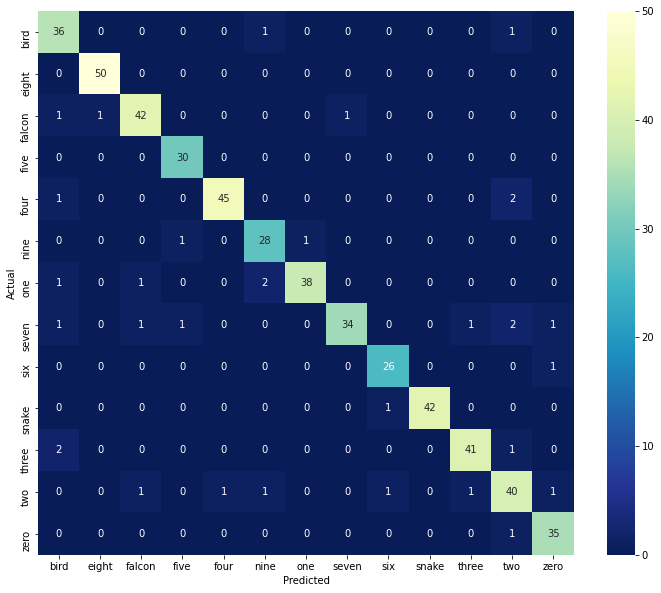

In [28]:
# ----- SAVE THE BEST FOLD MODEL -----
best_fold_index = save_best_fold(loss_list, acc_list, model_state_list, train_loss_list, train_acc_list, FILENAME)

# ----- GET THE F1 SCORE AND CONFUSION MATRIX -----
metrics_helper(val_list, val_filename_array, val_pred_array, best_fold_index, FILENAME)

## Test Set

In [ ]:
# THIS TEST SET MIGHT BE WRONG
#!gdown --id 1AvP49xengGjnFTG209AgvAGj-by8WGSi
#!unzip -q -o s1_test.zip

In [29]:
# THIS TEST SET IS CORRECT
!unzip -q -o './drive/My Drive/TIL2021/competition/SC/s1_test_release.zip' -d "./content/" 

In [30]:
# Initialise dataset object for test set
#test_set = CustomSpeechDataset(path='s1_test', typ='test')
test_set = CustomSpeechDataset(path='./content/s1_test_release', typ='test')


## Load back any model that was saved earlier


In [31]:
# ----- MODEL CONFIGURATION -----
HIDDEN_SIZE = 256 #256
NUM_LAYERS = 2 #2
BATCH_SIZE = 32 #64
OPTIM_NAME = 'adagrad' #'adam'
EPOCHS = 30 #30

FILENAME = f'SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}'

# ----- LOAD BACK THE MODEL -----
model = RNN(input_size=128, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=len(labels), device=device, classes=labels).to(device)
print(model.load_state_dict(torch.load(f'{COLAB_FILEPATH}model/model-{FILENAME}.pt')))
print(f'Loaded filepath: {COLAB_FILEPATH}model/model-{FILENAME}.pt')



<All keys matched successfully>
Loaded filepath: ./drive/My Drive/TIL2021/competition/SC/model/model-SC-BiGru_lr-1e-03_TM-5_FM-5_HS-256_NL-2_BS-32_OP-adagrad_EP-30.pt


## Test the model with the test set

In [32]:
# define test collate function and set up test loader

def test_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate

    tensors, filenames = [], []

    # Gather in lists
    for filename, waveform, sample_rate in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)

    return (tensors, filenames)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    collate_fn=test_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

In [33]:
# pass test set through the RNN model
model.eval()
pred_list, filename_list = [], []
with torch.no_grad():
  for idx, (features, filenames) in enumerate(test_loader):

    features = features.to(device)

    # forward pass
    outputs = model(features)

    # test results
    _, argmax = torch.max(outputs, 1)
    pred_list += argmax.cpu().tolist()
    filename_list += filenames

In [34]:
print(pred_list[:5]) 
print(filename_list[:5])


[1, 7, 7, 7, 10]
['s1_test_0176.wav', 's1_test_0544.wav', 's1_test_0636.wav', 's1_test_0491.wav', 's1_test_0127.wav']


## Submission of Results
Submission csv file should contain only 2 columns for filename and label, in that order. The file should be sorted by filename, and exclude headers. 

Refer to **sample_submission.csv** for an example.

In [35]:
result_tuple = list(zip(filename_list, pred_list))
#print(result_tuple)
submission = pd.DataFrame(result_tuple, columns=['filename', 'pred'])
submission = submission.sort_values('filename').reset_index(drop=True)
submission['label'] = submission['pred'].apply(lambda x: labels[x])

In [36]:
submission[['filename', 'label']].head()

,filename,label
0,s1_test_0000.wav,two
1,s1_test_0001.wav,seven
2,s1_test_0002.wav,four
3,s1_test_0003.wav,snake
4,s1_test_0004.wav,four


In [37]:
submission["label"].value_counts()

two       58
four      54
seven     50
falcon    50
snake     50
eight     50
nine      50
zero      50
three     50
bird      48
one       48
six       47
five      44
Name: label, dtype: int64

In [38]:
submission[['filename', 'label']].to_csv(f'{COLAB_FILEPATH}submission/submission-{FILENAME}.csv', header=None, index=None)